In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
import mlflow

In [96]:
# hyperparameters
NUM_EPOCHS = 25
BATCH_SIZE = 4
LAYERS_TRAINED = 1

# use balanced torch imagefolder dataset
fraction = 0.33

In [97]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(3),
        transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(3),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '/home/riikoro/fossil_data/tooth_samples/torch_imagefolder_2/MPI'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names

['I', 'M', 'P']

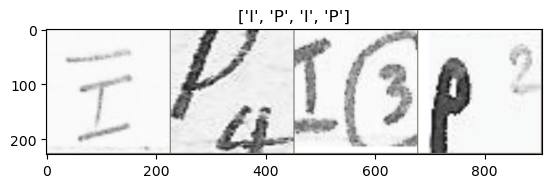

In [98]:

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

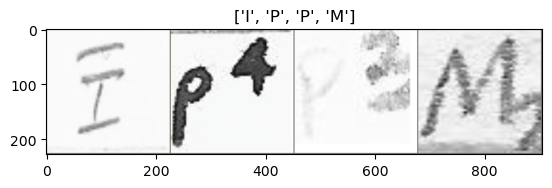

In [99]:
# Get a batch of test data
inputs, classes = next(iter(dataloaders['test']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [105]:
model_conv = torchvision.models.vgg16()
for param in list(model_conv.parameters())[:-1*LAYERS_TRAINED]:
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6] = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

for param in model_conv.parameters():
    print(param.requires_grad)
model_conv

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [106]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, best_acc, epoch_acc

In [107]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv, test_acc, train_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=NUM_EPOCHS)

Epoch 0/24
----------
train Loss: 1.1030 Acc: 0.3521
test Loss: 1.1317 Acc: 0.2778

Epoch 1/24
----------
train Loss: 1.1114 Acc: 0.3375
test Loss: 1.1288 Acc: 0.2778

Epoch 2/24
----------
train Loss: 1.0961 Acc: 0.3312
test Loss: 1.0954 Acc: 0.2778

Epoch 3/24
----------
train Loss: 1.1009 Acc: 0.3771
test Loss: 1.0624 Acc: 0.4259

Epoch 4/24
----------
train Loss: 1.0877 Acc: 0.3854
test Loss: 1.0837 Acc: 0.4074

Epoch 5/24
----------
train Loss: 1.0736 Acc: 0.3937
test Loss: 1.0443 Acc: 0.6296

Epoch 6/24
----------
train Loss: 1.0762 Acc: 0.4125
test Loss: 1.0404 Acc: 0.3889

Epoch 7/24
----------
train Loss: 1.0727 Acc: 0.3896
test Loss: 1.0380 Acc: 0.6852

Epoch 8/24
----------
train Loss: 1.0543 Acc: 0.5062
test Loss: 1.0388 Acc: 0.7037

Epoch 9/24
----------
train Loss: 1.0626 Acc: 0.4437
test Loss: 1.0386 Acc: 0.7037

Epoch 10/24
----------
train Loss: 1.0607 Acc: 0.4500


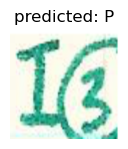

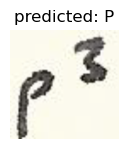

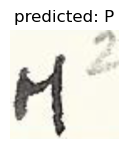

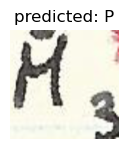

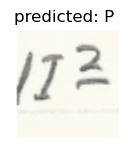

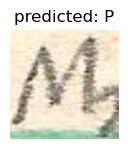

In [10]:

visualize_model(model_conv)

plt.ioff()
plt.show()

In [104]:
%env MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db
mlflow.set_experiment("MPIC")

params = {
    'data_v': [3,4,5],
    'train_size': dataset_sizes['train'],
    'test_size': dataset_sizes['test'],
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'base_model_path': 'torchvision.models.vgg16',
    'preprocessing': 'grayscaling, normalization, random crop',
    'layers_trained': f'last {LAYERS_TRAINED}'
}

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("most frequent class occurence fraction", fraction)
    mlflow.log_metric("training accuracy", train_acc)
    mlflow.log_metric("test accuracy", test_acc)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("info", "AlexNet, data grayscaled.")

env: MLFLOW_TRACKING_URI=sqlite:///../../mlflow.db


kyssäri. miks mun malli on dummy ja antaa kaikkeen 'P'?

mallin outputti ei summaa ykköseen, ei oo softmaxii????

In [72]:
test_dataloader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=10)

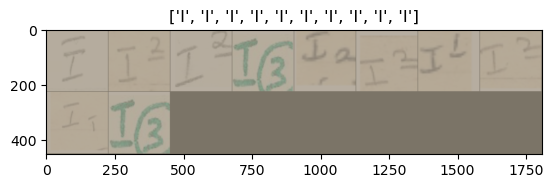

In [77]:

images, labels = next(iter(test_dataloader))
# print(image.shape, label.shape)
# imshow(image[0])
out = torchvision.utils.make_grid(images)

imshow(out, title=[class_names[x] for x in labels])

In [78]:
out = model_conv(image)

In [84]:
nn.functional.softmax(out,1)

tensor([[0.3334, 0.3296, 0.3370],
        [0.3334, 0.3296, 0.3371],
        [0.3334, 0.3296, 0.3370],
        [0.3332, 0.3297, 0.3371],
        [0.3334, 0.3296, 0.3371],
        [0.3333, 0.3296, 0.3371],
        [0.3333, 0.3296, 0.3371],
        [0.3334, 0.3296, 0.3371],
        [0.3334, 0.3296, 0.3371],
        [0.3332, 0.3297, 0.3372]], grad_fn=<SoftmaxBackward0>)